This Jupyter notebook will use SEAScope viewer and SEAScope python bindings to retrieve inputs data
* author: Lucile Gaultier, OceanDataLab
* date: 2024-10-12

To install SEAScope and python bindings, follow instruction on <a href="https://www.youtube.com/playlist?list=PL_Nrq3gZvmM_C8baJBiNEzMjg0Hg7FIgK"> OceanDataLab youtube HOW TO Playlist </a>


<div class="alert alert-block alert-success">
    <h1><center>Study the Climatology of SST and Chlorophyll using CCI products</center></h1></div>

<div class="alert alert-block alert-warning">
    
 <b> The following collection from your SEAScope catalogue will be used in this Jupyter notebook: </b>
<ol>    
    <li> directory: `sst_monthly_esa_cci`, label: `SST monthly ESA CCI` </li>
    <li> directory: `sst_anomaly_monthly_esa_cci`, label: `SST anomaly monthly ESA CCI` </li>
    <li> directory: `chl_monthly_esa_cci`, label: `Chlorophyll monthly ESA CCI` </li>
    <li> directory: `chl_anomaly_monthly_esa_cci`, label: `Chlorophyll anomaly monthly ESA CCI` </li>
        </ol> 
Check that you have them in your catalogue before starting this Jupyter 

Collections can be downloaded at <a href="https://ftp.odl.bzh/odl/events/otc25/data-cci."> link to data</a>
</div>

The SST and Chlorophyll products are coming from ESA Climate Change Initiative projects. 
They have been processed to compute monthly averages and anomalies. 

1. SST monthly averages are computed averaging daily SST CCI v3 data for each month
2. SST anomalies are computed by substracting SST monthly averages with SST monthly climatologies computed from the 1982-2010 period
3. Chlorophyll monthly averages are coming directly from the Ocean Color CCI project, the logarithm of the Chlorophyll is computed for better dynamics rendering
4. Chlorophyll anomalies monthly are computed by substracting the monthly Chlorophyll with monthly climatologies computed on the 1998-2010 period. A symetric logarithm is computed on these anomalies to better see the dynamics:
   
   $$ log(chl) + a \ for\ chl>10^{-a} $$
   $$ -log(-chl) - a \ for\ chl<-10^{-a} $$
   $$ a * chl \ for\ -10^{-a}<=chl<=10^{-a} $$
we use 

## Import modules

In [29]:
# Import necessary module
import matplotlib
%matplotlib inline
import numpy
import os
from scipy import ndimage
import xarray


## Define reading function

Xarray is used to and build the 3D cube (time, lat, lon) on your chosen area

In [30]:
def load_data(path, var, box):
    data_all = xarray.open_mfdataset(f'{path}/*/*.nc')
    lllon, urlon, lllat, urlat = box
    data = data_all.sel(lon_gcp=slice(lllon, urlon), lat_gcp=slice(lllat, urlat))

    llindlon = data['index_lon_gcp'].values[0, 0]
    urindlon = data['index_lon_gcp'].values[0, -1]
    llindlat = data['index_lat_gcp'].values[0, 0]
    urindlat = data['index_lat_gcp'].values[0, -1]
    var = 'analysed_sst'
    data = data.isel(lat=slice(llindlat, urindlat), lon=slice(llindlon, urindlon))
    data_mean = data.mean(dim=["lon", "lat"])

    return data_mean

## Get data using SEAScope viewer and python bindings 


In the data viewer, select the following data:
* collection `Chlorophyll Monthly ESA CCI`, variable `chlorophylle`
* collection `Chlorophyll Anomaly Monthly ESA CCI`, variable `chlorophylle`
* collection `Chlorophyll Monthly ESA CCI`, variable `chlorophylle`
* collection `Chlorophyll Monthly ESA CCI`, variable `chlorophylle`

Choose in the calendar a month that are of interest for you and draw a rectange to extract data using SEAScope. Click on the extract button on the polygon window


Tutorial videos are available  on [How to export data from SEAScope](https://youtu.be/jN-67nwWbUA) video  on YouTube here to show you how to draw a shape and extract data using SEAScope

In [31]:
# Load data from viewer memory
from SEAScope.lib import get_extracted_data
extractions = get_extracted_data()
granule_id = None
print('\n'.join(extractions.keys()))
list_extractions = list(extractions.keys())
path = {}
var = {}
granules = {}
for k, data in enumerate(list_extractions):
    name_path = os.path.dirname(os.path.abspath(data))
    if 'cci' not in name_path:
        continue
    bn = os.path.basename(data)
    if 'SST' in bn:
        key = 'SST'
    else:
        key = 'Chl'
    if 'diff' in bn:
        key = f'anomaly {key}'
    path[key] = os.path.abspath(os.path.join(name_path, os.pardir))
    var[key] = list(extractions[data]['data'].keys())[0]
    granules[key] = extractions[data]

/Users/lgaultier/SEAScope-workspace/data/sst_esa_cci/201205-ESACCI-L4_GHRSST-SSTdepth-OSTIA-GLOB_CDR3.0-v02.0-fv01.0/201205-ESACCI-L4_GHRSST-SSTdepth-OSTIA-GLOB_CDR3.0-v02.0-fv01.0_idf_00.nc
/Users/lgaultier/SEAScope-workspace/data/sst_anomaly_monthly_esa_cci/201205-diffESACCI-L4_GHRSST-SSTdepth-OSTIA-GLOB_CDR3.0-v02.0-fv01.0/201205-diffESACCI-L4_GHRSST-SSTdepth-OSTIA-GLOB_CDR3.0-v02.0-fv01.0_idf_00.nc
/Users/lgaultier/SEAScope-workspace/data/chl_monthly_esa_cci/ESACCI-OC-L3S-CHLOR_A-MERGED-1M_MONTHLY_4km_GEO_PML_OCx-201205-fv6.0/ESACCI-OC-L3S-CHLOR_A-MERGED-1M_MONTHLY_4km_GEO_PML_OCx-201205-fv6.0_idf_01.nc
/Users/lgaultier/SEAScope-workspace/data/chl_anomaly_monthly_esa_cci/diff-ESACCI-OC-L3S-CHLOR_A-MERGED-1M_MONTHLY_4km_GEO_PML_OCx-201205-fv6.0/diff-ESACCI-OC-L3S-CHLOR_A-MERGED-1M_MONTHLY_4km_GEO_PML_OCx-201205-fv6.0_idf_01.nc


In [32]:
## Plot your data to check the extracted area

/var/folders/z7/4lwcwxzn7cb0kkv386jr6pl40000gn/T/ipykernel_43227/2208986362.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(lon2D, lat2D, array)
/Users/lgaultier/data/env/seascope/lib/python3.12/site-packages/matplotlib/colors.py:732: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


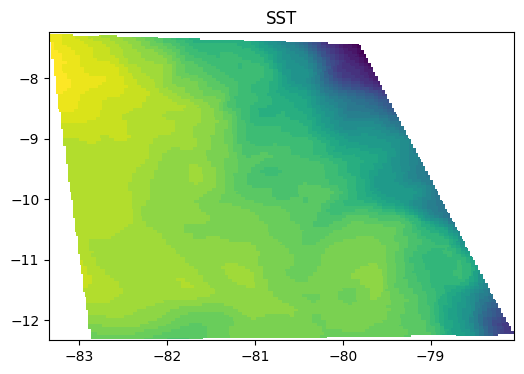

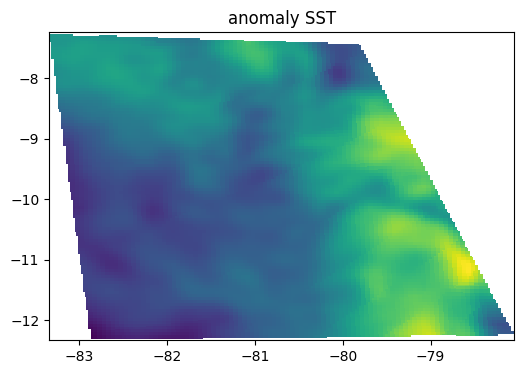

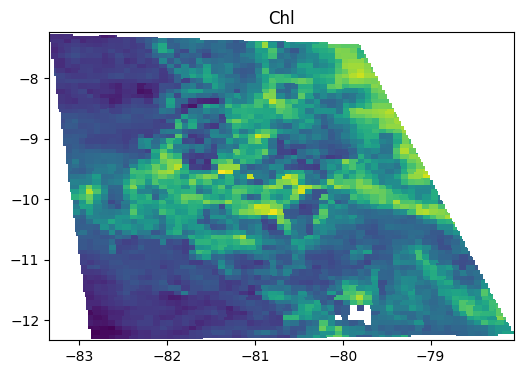

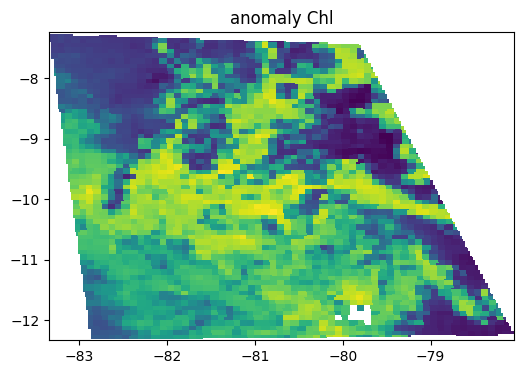

In [33]:
from SEAScope.lib.utils import get_lonlat

for key, granule in granules.items():
    array = granule['data'][var[key]]
    lon2D, lat2D = get_lonlat(granule, numpy.shape(array))
    fig, ax =  matplotlib.pyplot.subplots(figsize=(6, 4))
    ax.pcolormesh(lon2D, lat2D, array)
    date = granule['meta']['start']  
    ax.set_title(key)


## Load the 3D cube using xarray for each selected data and average data spatially in the area

In [34]:
lllon = numpy.min(lon2D)
lllat = numpy.min(lat2D)
urlon = numpy.max(lon2D)
urlat = numpy.max(lat2D)
print(f'Extracted box is [{lllon:.2f}, {urlon:.2f}, {lllat:.2f}, {urlat:.2f}]')
data = {}
for key in granules.keys():
    if 'SST' in key:
        data[key] = load_data(path[key], var[key], [lllon, urlon, lllat, urlat])
    else:
        data[key] = load_data(path[key], var[key], [lllon, urlon, urlat, lllat]) 

Extracted box is [-83.33, -78.06, -12.32, -7.25]


In [35]:
## Plot temporal variation of Chlorophyll and SST averaged in your area

Text(0.5, 1.0, 'temporal evolution')

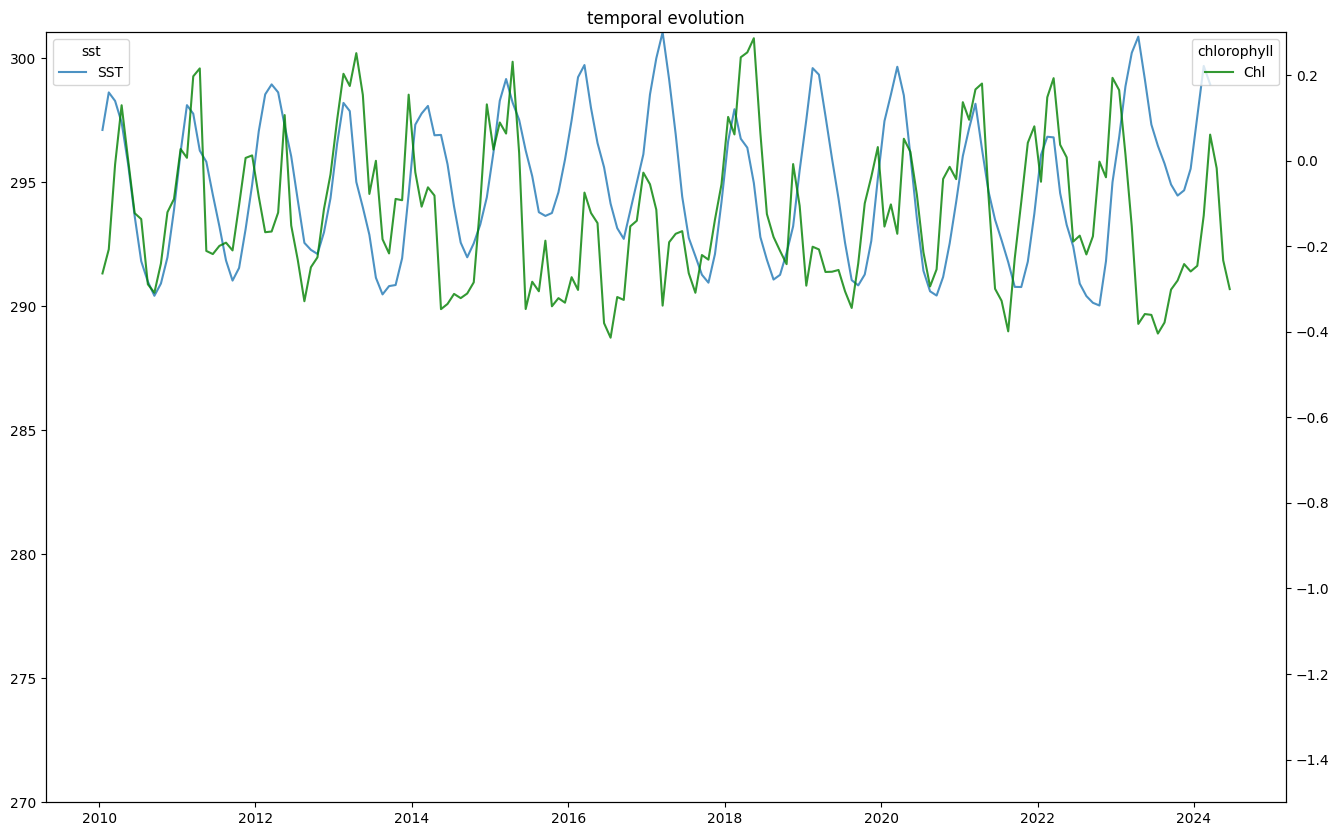

In [36]:
fig, ax =  matplotlib.pyplot.subplots(figsize=(16, 10))
for key, value in data.items():
    if 'anomaly' in key: continue
    if 'SST' in key:
        ax.plot(value['time'], value[var[key]], label=key, alpha=0.8)
        ax.legend(loc='upper left', title='sst')
        ax.set_ylim([270, max(295, numpy.max( value[var[key]]))])
    else:
        ax2 = ax.twinx()   
        ax2.plot(value['time'], value[var[key]], 'g', label=key, alpha=0.8)
        ax2.legend(loc='upper right', title='chlorophyll')
        ax2.set_ylim([-1.5, 0.3])
matplotlib.pyplot.title(f'temporal evolution')

## Plot temporal variation of Chlorophyll anomalies and SST anomalies averaged in your area

Text(0.5, 1.0, 'temporal evolution')

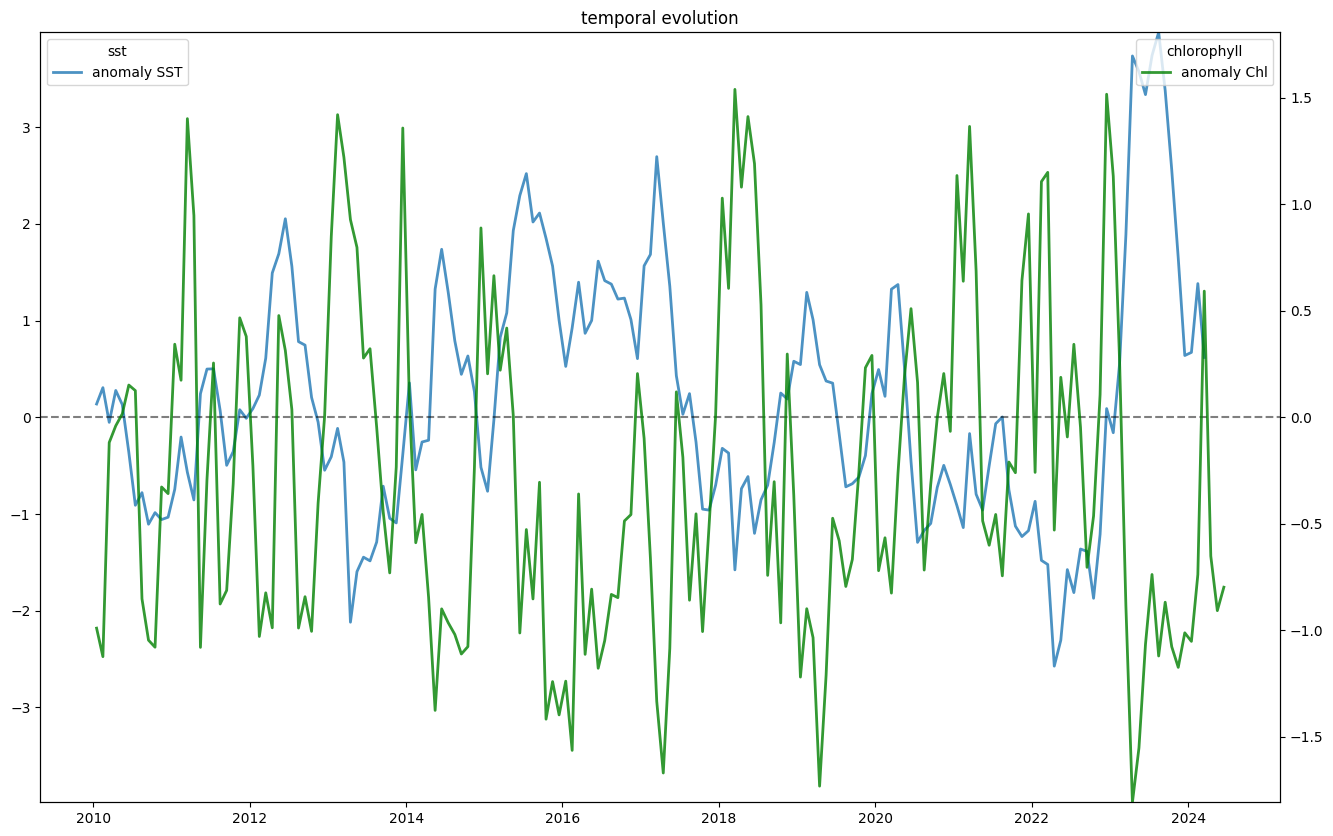

In [40]:
fig, ax =  matplotlib.pyplot.subplots(figsize=(16, 10))
for key, value in data.items():
    if 'anomaly' not in key: continue
    _min = numpy.nanmin(value[var[key]])
    _max = numpy.nanmax(value[var[key]])
    _extr = max(abs(_min), abs(_max))
    if 'SST' in key:
        ax.plot(value['time'], value[var[key]], label=key,
                linewidth=2,alpha=0.8)
        ax.legend(loc='upper left', title='sst')
        ax.axhline(y=0, linestyle='--', color='k', alpha=0.5)
        ax.set_ylim([-_extr, _extr])
    else:
        ax2 = ax.twinx()   
        ax2.plot(value['time'], value[var[key]], 'g', label=key,
                 linewidth=2, alpha=0.8)
        ax2.legend(loc='upper right', title='chlorophyll')
        ax2.set_ylim([-_extr, _extr])
matplotlib.pyplot.title(f'temporal evolution')

## Plot temporal variation of SST and Chlorophyll for the month chosen during the extraction 

Text(0.5, 1.0, 'temporal evolution for month 5')

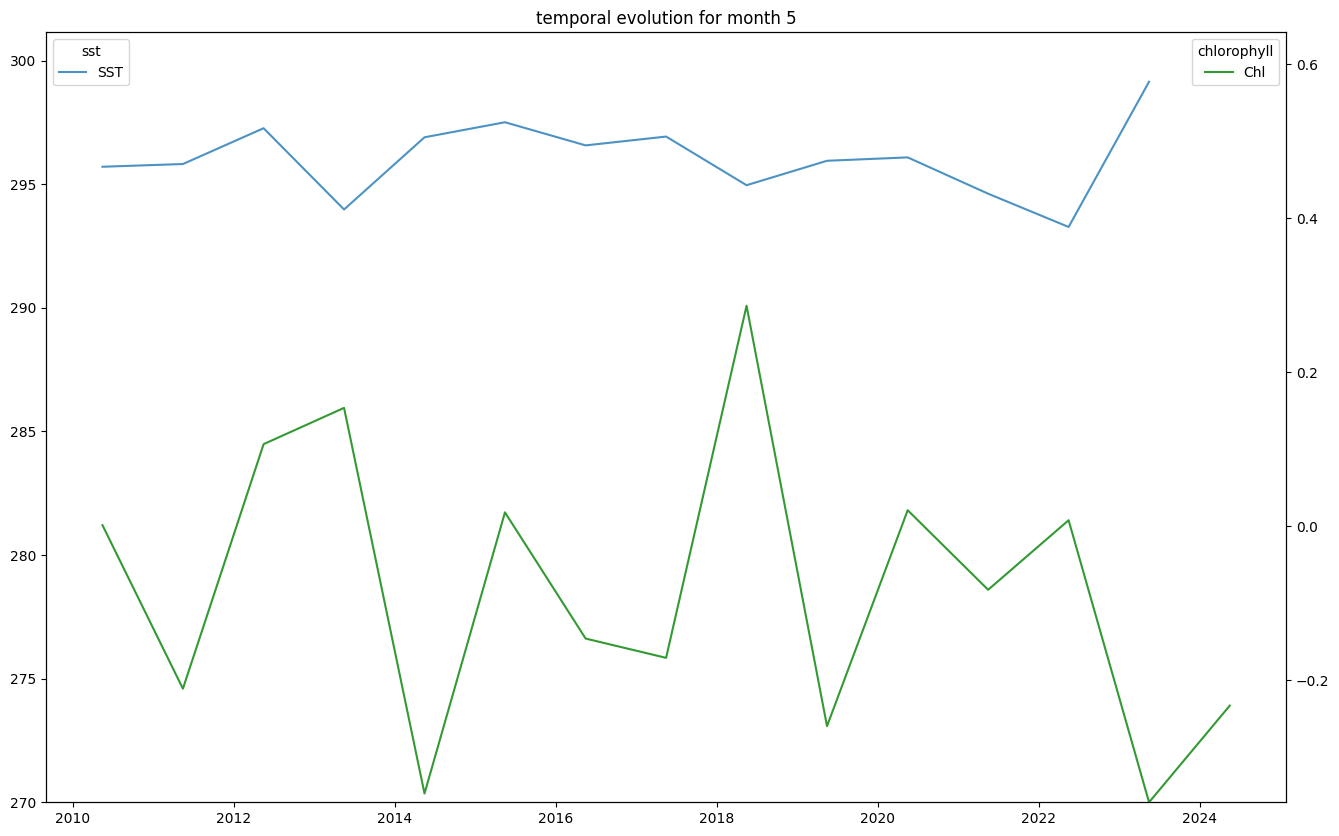

In [41]:
fig, ax =  matplotlib.pyplot.subplots(figsize=(16, 10))
for key, value in data.items():
    if 'anomaly' in key: continue
    seasonal = value.sel(time=(value['time.month'] == date.month))
    if 'SST' in key:
        ax.plot(seasonal['time'], seasonal[var[key]], label=key, alpha=0.8)
        ax.legend(loc='upper left', title='sst')
        ax.set_ylim([270, numpy.max(seasonal[var[key]])+2])
    else:
        ax2 = ax.twinx()   
        ax2.plot(seasonal['time'], seasonal[var[key]], 'g', label=key, alpha=0.8)
        ax2.legend(loc='upper right', title='chlorophyll')
        ax2.set_ylim([numpy.min(seasonal[var[key]]),numpy.min(seasonal[var[key]])+1])
matplotlib.pyplot.title(f'temporal evolution for month {date.month}')



## Plot temporal variation of SST anomalies and Chlorophyll anomalies for the month chosen during the extraction 

Text(0.5, 1.0, 'temporal evolution for month 5')

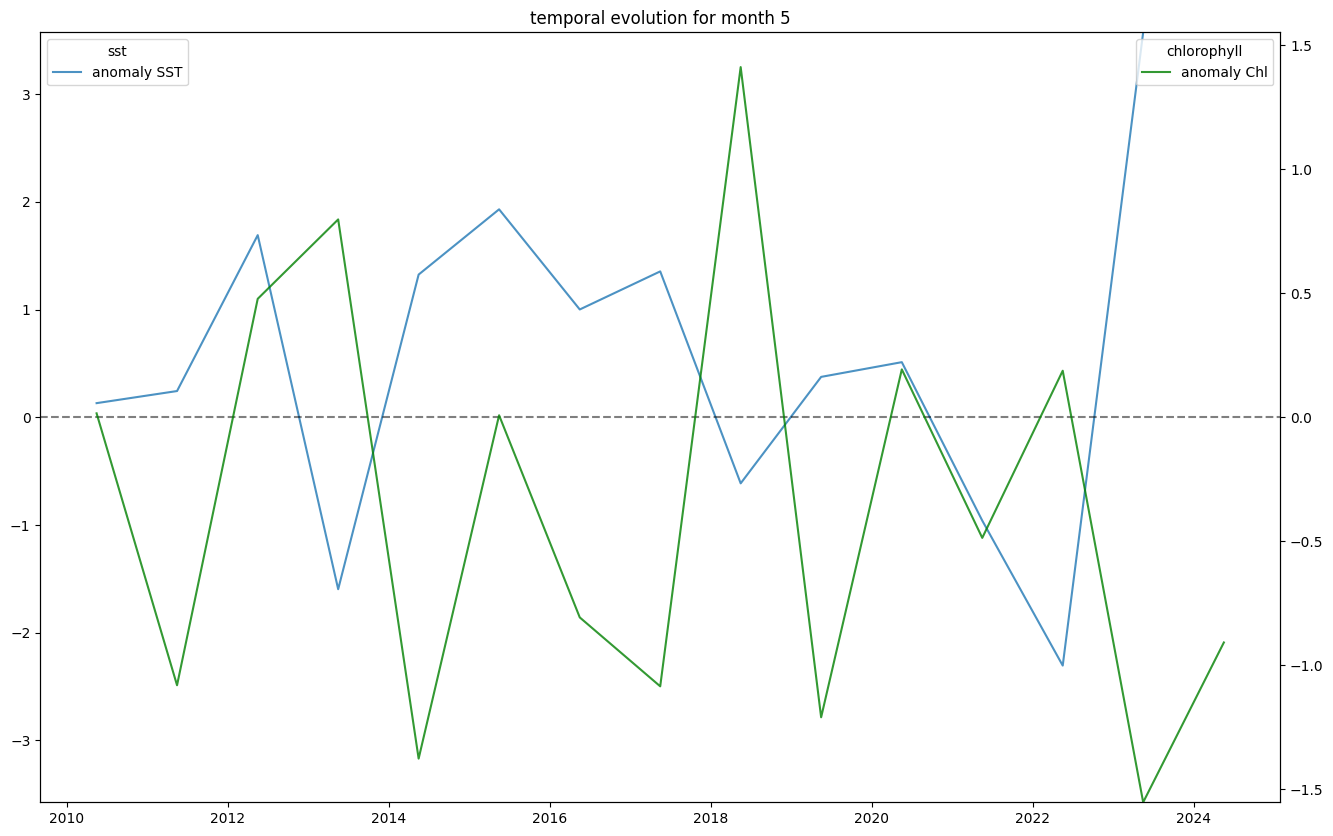

In [42]:
fig, ax =  matplotlib.pyplot.subplots(figsize=(16, 10))
for key, value in data.items():
    if 'anomaly' not in key: continue
    seasonal = value.sel(time=(value['time.month'] == date.month))
    _min = numpy.nanmin(seasonal[var[key]])
    _max = numpy.nanmax(seasonal[var[key]])
    _extr = max(abs(_min), abs(_max))
    if 'SST' in key:
        ax.plot(seasonal['time'], seasonal[var[key]], label=key, alpha=0.8)
        ax.legend(loc='upper left', title='sst')
        ax.axhline(y=0, linestyle='--', color='k', alpha=0.5)
        ax.set_ylim([-_extr, _extr])

    else:
        ax2 = ax.twinx()   
        ax2.plot(seasonal['time'], seasonal[var[key]], 'g', label=key, alpha=0.8)
        ax2.legend(loc='upper right', title='chlorophyll')
        ax2.set_ylim([-_extr, _extr])
matplotlib.pyplot.title(f'temporal evolution for month {date.month}')

In [318]:
# min max sst -5, 5
# make videos
